### Normal Waveform Dataset Generation

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import random
import pickle
import importlib

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import wandb

from data_utils import *
from waveforms.waveforms_module.make_waveform import BatchedLightSimulation

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

g = torch.Generator()
g.manual_seed(seed)

In [2]:
pwd

'/sdf/home/c/carsmith/flash_reconstruction/self_supervised_flash/notebooks'

In [4]:
device = torch.device('cuda:0')
sim = BatchedLightSimulation(cfg="../../waveforms/templates/waveform_sim.yaml").to(device)

# Changing Resolution & Other Params
# Note: Delay distributions' time parameters are in units of microseconds
# Some other params relating to waveform length are in units of nanoseconds

params = dict()
params['light_tick_size'] = 0.001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 10
params['tpb_tau'] = 0.002 # us
params['offset'] = 0 # ns
params['n_ticks'] = 80000 # ns

# Picking nominal values for all - MUST set these to be constant between datasets
params['light_gain'] = -45.0
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
sim.reconfigure(params)

print(f"1 time tick = {sim.light_tick_size} microseconds.")
print(f"Downsample by factor of {sim.downsample_factor}.")
print(f"Offset flash by {sim.offset} ns from window start.")
print(f"Waveforms are {sim.n_ticks} ns long.")
print(f"Light gain is {sim.light_gain} ADC.")

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001                     # us
	LIGHT_WINDOW: [1, 10]
1 time tick = 0.001 microseconds.
Downsample by factor of 10.
Offset flash by 0 ns from window start.
Waveforms are 80000 ns long.
Light gain is Parameter containing:
tensor(1., device='cuda:0', requires_grad=True) ADC.


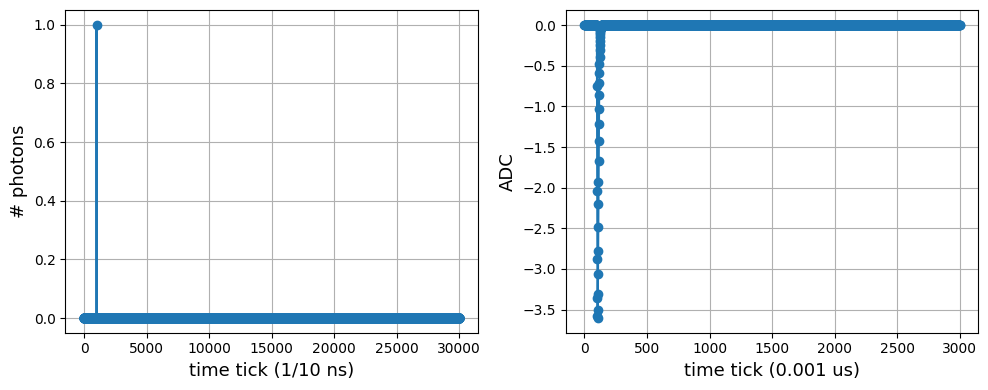

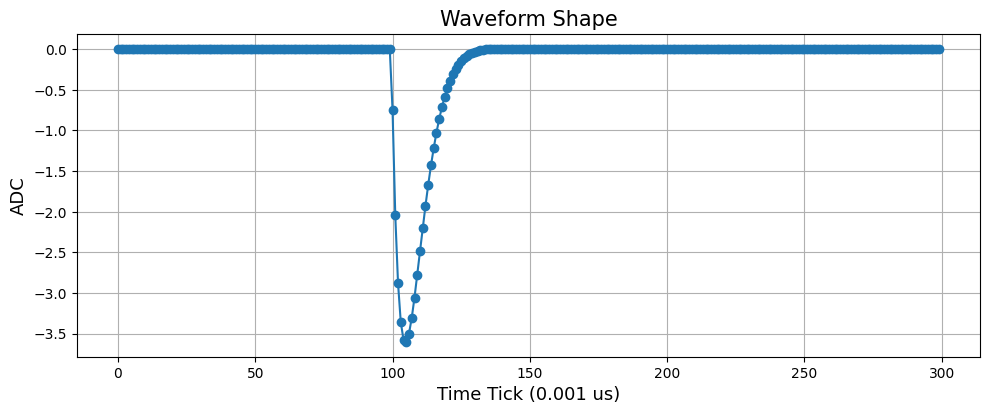

In [5]:
# Generating Waveform
nphotons = 1
pmt_ids = torch.zeros(nphotons, dtype=torch.int64)
arrival_times = torch.zeros(nphotons, dtype=torch.int64) + 1000 # pre-delay, arrive at 100 ns
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)

# Electronics Convolution
output, _ = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot
axes[0].plot(wf[0][:30000], marker = 'o')
axes[0].set_ylabel("# photons", fontsize=13)
axes[0].set_xlabel("time tick (1/10 ns)", fontsize=13)
axes[0].grid(True)
axes[1].plot(output[:3000], marker='o')
axes[1].grid(True)
axes[1].set_xlabel(f"time tick ({sim.light_tick_size} us)", fontsize=13)
axes[1].set_ylabel("ADC", fontsize=13)
plt.tight_layout()
plt.show()

# Second plot
plt.figure(figsize=(10, 4))
plt.plot(output[:300], marker='o')
plt.grid(True)
plt.xlabel(f"Time Tick ({sim.light_tick_size} us)", fontsize=13)
plt.ylabel("ADC", fontsize=13)
plt.tight_layout()
plt.title("Waveform Shape", fontsize=15)
plt.show()

In [6]:
single_phot_amplitude = output.min()
print(single_phot_amplitude)

PATH_TO_SAVE = '/sdf/home/c/carsmith/sdf_data/self_supervised_flash/data/test.npy'

-3.6047788


### Using Knowledge of Start Times etc. to Generate Labels w/ Heuristic
* Always include 4 tokens after start time as `rising edge`
* Keep including tokens after rising edge as `tail` until slope is x for n tokens in a row
* Everything else is `background`

In [7]:
num_waveforms = 100
labels_per_waveform = 800
max_hits = 8
segment_size = 10

sim_waveforms = []
per_wf_arrival_times = []
per_wf_latest_photon_times = []
per_wf_num_photons = []
per_wf_labels = []

ns_all = np.repeat(np.arange(10, 1001), 100) # single flash benchmark gen

for i in range(num_waveforms):
    nhits = np.random.randint(2, max_hits + 1)
    ns = np.random.randint(10, 1001, size=nhits)
    # ns = np.array([ns_all[i]])
    per_wf_num_photons.append(ns)
    
    total_photons = ns.sum()
    pmt_ids = torch.zeros(total_photons, dtype=torch.int64)
    arrival_times = np.random.randint(50, 70001, size=nhits)
    per_wf_arrival_times.append(arrival_times / sim.downsample_factor)

    arrival_times_tensor = torch.cat([
        torch.full((ns[j],), arrival_times[j], dtype=torch.int64) # in 100 picoseconds
        for j in range(nhits)
    ])

    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), combined=True)
    output = output.detach().cpu().numpy() # in units of nanoseconds
    
    # Calculating longest delayed photon in each flash
    per_flash_latest_phot = []
    running_phot_sum = 0
    info['scintillation_delays'] = np.array(info['scintillation_delays'])
    info['tpb_emission_delays'] = np.array(info['tpb_emission_delays'])

    flash_ids = np.repeat(np.arange(nhits), ns)

    for i in range(nhits):
        mask = (flash_ids == i)
        if not np.any(mask):
            # no photons survived for this flash; stay safe
            per_flash_latest_phot.append(
                arrival_times[i] / sim.downsample_factor
            )
            continue

        full_delay = (info['scintillation_delays'][mask] + info['tpb_emission_delays'][mask]) * (1000 / sim.downsample_factor)
        max_delay = max(full_delay)
    
        arrival_ns = arrival_times[i]
        arrival_bins = arrival_ns / sim.downsample_factor  # convert ns → waveform bins
    
        per_flash_latest_phot.append(arrival_bins + max_delay)
        
    per_wf_latest_photon_times.append(np.array(per_flash_latest_phot))

    # Add Gaussian noise
    noise = np.random.normal(0, 0.2 * abs(single_phot_amplitude), size=output.shape)
    signal = output + noise

    L = len(signal)
    n_segments = L // segment_size
    
    segment_indices = np.arange(n_segments)[:, None]   # shape (n_segments, 1)

    ##############################################################
    # tail mask
    start_tail = arrival_times // (segment_size * sim.downsample_factor) # in units of SEGMENT IDS
    per_flash_latest_phot = np.array(per_flash_latest_phot)
    end_tail = np.minimum(np.floor((per_flash_latest_phot + 47) / segment_size).astype(int), n_segments)
    
    all_tail_mask = np.zeros(n_segments, dtype=bool)
    
    for i in range(len(start_tail)):
        s = start_tail[i]
        e = end_tail[i]
    
        if e <= s:
            continue
    
        all_tail_mask[s:e] = True
        
    
    # rise mask
    start_rise = start_tail
    rise_seg = int(4 * (10 / segment_size))
    end_rise = np.minimum(start_rise + rise_seg, n_segments)
    
    rise_mask = np.zeros(n_segments, dtype=bool)
    for i in range(len(start_rise)):
        s = start_rise[i]
        e = end_rise[i]
        if e <= s:
            continue
        rise_mask[s:e] = True
    
    # assign labels
    labels = np.zeros(n_segments, dtype=np.int64)
    labels[all_tail_mask] = 2
    labels[rise_mask] = 1     # override tails where rise occurs
    ##############################################################

    per_wf_labels.append(labels)
    sim_waveforms.append(signal)

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = per_wf_arrival_times # list of arrays, containing arrival_time per hit per wf
data['num_photons'] = per_wf_num_photons # list of arrays, containing n_photons per hit per wf
data['token_labels'] = per_wf_labels
data['last_phot_arrival'] = per_wf_latest_photon_times
np.save(PATH_TO_SAVE, data, allow_pickle=True)

In [8]:
print(per_flash_latest_phot)
print(start_tail)
print(end_tail)
print(sim.offset)

[1115.82189245 2815.0316715  4101.38223351 3505.171313  ]
[  3 195 312 250]
[116 286 414 355]
0


Arrival times: [5536.9 3729.2]


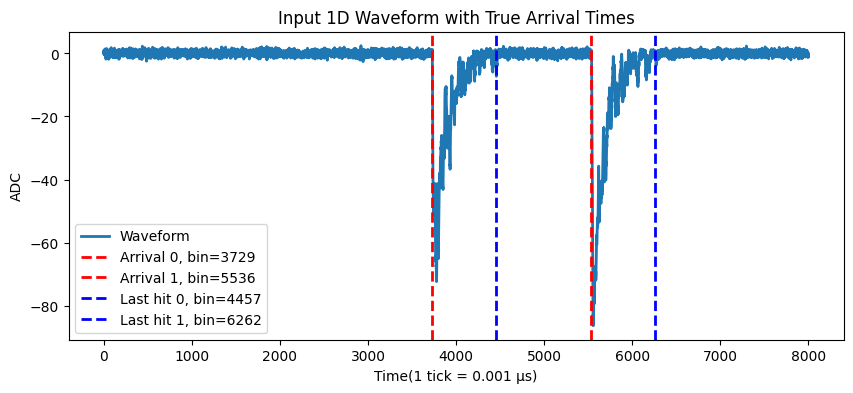

In [9]:
waveforms = np.load(PATH_TO_SAVE, allow_pickle=True).item()
waveform_id = 13

wf = waveforms['waveforms'][waveform_id]

ticks = np.arange(len(wf))
plt.figure(figsize=(10, 4))
plt.plot(ticks, wf, linewidth=2, label="Waveform")

t = waveforms['arrival_times'][waveform_id]
l = waveforms['last_phot_arrival'][waveform_id]
print("Arrival times:", t)

# Overlay arrival times as vertical dashed lines
for j, elem in enumerate(np.sort(t)):
    plt.axvline(
        x=elem,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Arrival {j}, bin={int(elem)}"
    )
# Mark latest photons
# for j, elem in enumerate(np.sort(l + 47)):
for j, elem in enumerate(np.sort(l)):
    plt.axvline(
        x=elem,
        color="b",
        linestyle="--",
        linewidth=2,
        label=f"Last hit {j}, bin={int(elem)}"
    )

plt.xlabel(f"Time(1 tick = {sim.light_tick_size} µs)")
plt.ylabel("ADC")
plt.title("Input 1D Waveform with True Arrival Times")
plt.legend()
plt.show()

#### Waveform w/ per-token labels

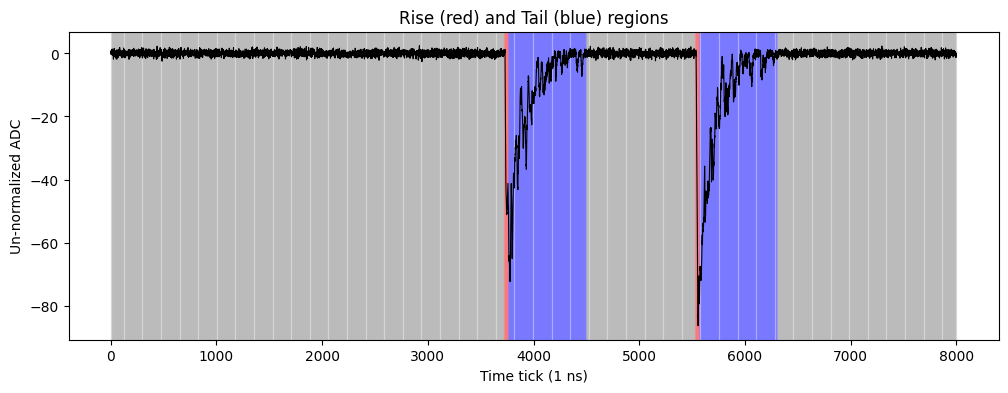

In [10]:
plt.figure(figsize=(12,4))
start = 0
end = 8000
plt.plot(sim_waveforms[waveform_id][start:end], color='black', lw=0.8)
for seg_idx, label in enumerate(per_wf_labels[waveform_id][start // segment_size:end // segment_size]):
    color = 'r' if label == 1 else 'b' if label == 2 else 'gray'
    plt.axvspan(seg_idx*segment_size, (seg_idx+1)*segment_size, color=color, alpha=0.2)

plt.title("Rise (red) and Tail (blue) regions")
plt.xlabel("Time tick (1 ns)")
plt.ylabel("Un-normalized ADC")
plt.show()

#### Zoomed Token Labels

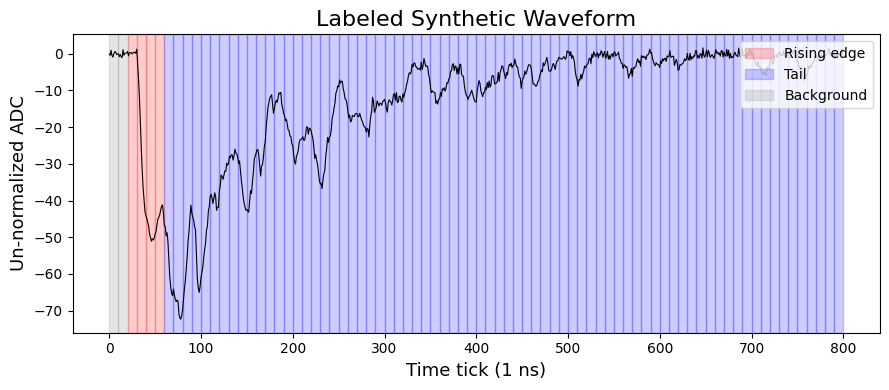

In [13]:
plt.figure(figsize=(9, 4))

start = 3700
end = 4500
segment_labels = per_wf_labels[waveform_id][start // segment_size : end // segment_size]

# Plot the waveform 
plt.plot(sim_waveforms[waveform_id][start:end], color='black', lw=0.8)

# Draw colored spans
for seg_idx, label in enumerate(segment_labels):
    color = 'r' if label == 1 else 'b' if label == 2 else 'gray'
    plt.axvspan(seg_idx*segment_size, (seg_idx+1)*segment_size, 
                color=color, alpha=0.2)

# Legend using proxy patches
legend_elements = [
    Patch(facecolor='red',  edgecolor='red',  alpha=0.2, label='Rising edge'),
    Patch(facecolor='blue', edgecolor='blue', alpha=0.2, label='Tail'),
    Patch(facecolor='gray', edgecolor='gray', alpha=0.2, label='Background'),
]

plt.legend(handles=legend_elements, loc='upper right')

plt.title("Labeled Synthetic Waveform", fontsize=16)
plt.xlabel("Time tick (1 ns)", fontsize=13)
plt.ylabel("Un-normalized ADC", fontsize=13)
plt.tight_layout()
plt.show()


### Calculating RMS of tail vs. background

0.7635251367451191
0.7107438459481906


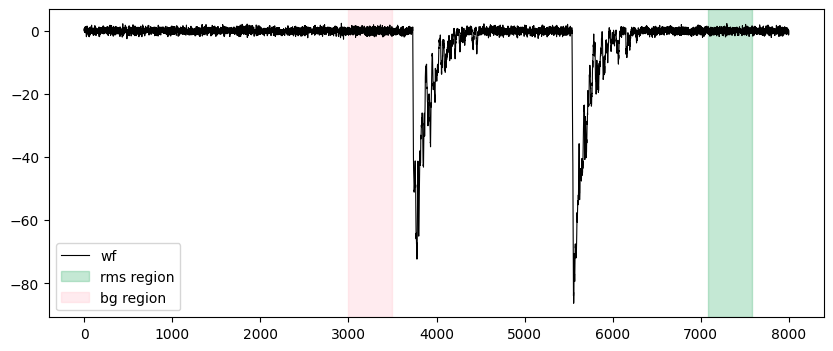

In [14]:
# Unnormalized Waveform
bg_region = sim_waveforms[waveform_id][3000:3500]
tail_start = 7086
tail_end = 7586
tail_region = sim_waveforms[waveform_id][tail_start:tail_end]
plt.figure(figsize=(10, 4))
plt.plot(sim_waveforms[waveform_id], color='black', lw=0.8, label = 'wf')
plt.axvspan(tail_start, tail_end, color='mediumseagreen', alpha=0.3, label='rms region')
plt.axvspan(3000, 3500, color='pink', alpha=0.3, label='bg region')

plt.legend()
bg_rms = np.linalg.norm(bg_region) / np.sqrt(len(bg_region))
t500_rms = np.linalg.norm(tail_region) / np.sqrt(len(tail_region))
print(bg_rms)
print(t500_rms)

In [56]:
# Normalized Waveform
unnorm_wf = sim_waveforms[waveform_id]
norm_wf = (unnorm_wf - unnorm_wf.mean()) / (unnorm_wf.std() + 1e-8)

0.40427057865454546
0.38667685660750856


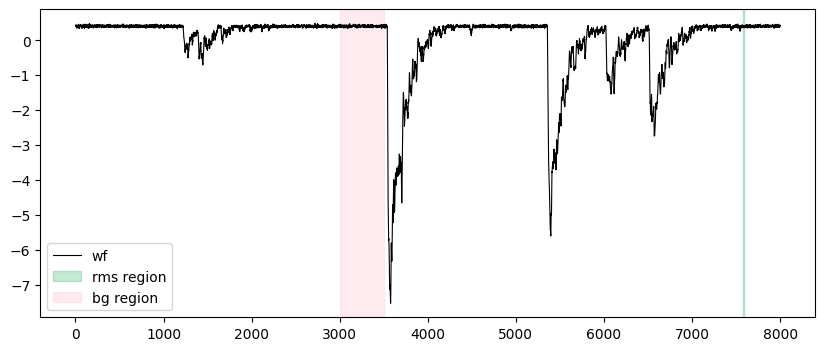

In [78]:
bg_region = norm_wf[3000:3500]
tail_start = 7576
tail_end = 7586
tail_region = norm_wf[tail_start:tail_end]
plt.figure(figsize=(10, 4))
plt.plot(norm_wf, color='black', lw=0.8, label = 'wf')
plt.axvspan(tail_start, tail_end, color='mediumseagreen', alpha=0.3, label='rms region')
plt.axvspan(3000, 3500, color='pink', alpha=0.3, label='bg region')

plt.legend()
bg_rms = np.linalg.norm(bg_region) / np.sqrt(len(bg_region))
t500_rms = np.linalg.norm(tail_region) / np.sqrt(len(tail_region))
print(bg_rms)
print(t500_rms)

In [17]:
train_loader, val_loader, test_loader = make_wf_dataloaders(PATH_TO_SAVE, val_ratio=0.1, generator=g, balanced=False)
data, target, hit_times, photon_target, photon_list, _, token_labels = next(iter(train_loader))

data keys: dict_keys(['waveforms', 'arrival_times', 'num_photons', 'token_labels', 'last_phot_arrival'])


### OLD: Validation accuracy from probing during pretraining 

Index(['Step', 'mask_unbal - val_accuracy', 'mask_unbal - val_accuracy__MIN',
       'mask_unbal - val_accuracy__MAX', 'dino_unbal - val_accuracy',
       'dino_unbal - val_accuracy__MIN', 'dino_unbal - val_accuracy__MAX',
       'mask_test - val_accuracy', 'mask_test - val_accuracy__MIN',
       'mask_test - val_accuracy__MAX'],
      dtype='object')
0         NaN
1         NaN
2         NaN
3         NaN
4    0.949461
5         NaN
6         NaN
7    0.931687
8    0.941659
9    0.935682
Name: mask_test - val_accuracy, dtype: float64


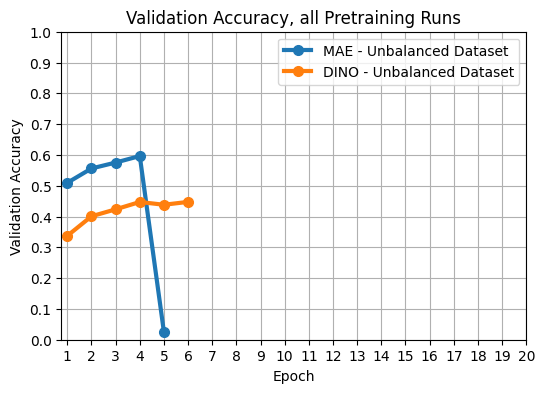

In [22]:
# Validation accuracy plots for unbalanced and balanced MAE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('pretraining_val_acc.csv')
print(df.keys())
ticks_test = np.array([5, 10, 15, 20])
ticks_unbal = np.array([1, 2, 3, 4, 5])
ticks_dino = np.array([1, 2, 3, 4, 5, 6])

print(df['mask_test - val_accuracy'])

# Plot only those points
plt.figure(figsize=(6,4))
plt.plot(ticks_unbal, df['mask_unbal - val_accuracy'].iloc[[0, 1, 2, 3, 5]], 'o-', label='MAE - Unbalanced Dataset', linewidth=3, markersize=7)
# plt.plot(ticks_test, df['mask_test - val_accuracy'].iloc[[4, 7, 8, 9]], 'o-', label='MAE - Balanced Dataset', linewidth=3, markersize=7)
plt.plot(ticks_dino, df['dino_unbal - val_accuracy'].iloc[[0, 1, 2, 3, 5, 6]], 'o-', label='DINO - Unbalanced Dataset', linewidth=3, markersize=7)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy, all Pretraining Runs")
plt.legend()
plt.grid(which='both')
plt.xticks(np.arange(1, 21))

# Set y-axis from 0 to 1 with ticks every 0.1
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.grid(True)
plt.show()